In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.nn import NNConv, global_mean_pool
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
# Check for CUDA (NVIDIA) or MPS (Apple)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load in the signal metadata
nubb_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_0nubb/1bar/5percent/reco_filtered/ATPC_0nubb_1bar_5percent_filtered.h5", "MC/hits")
nubb_meta["Type"] = "0nubb"
nubb_meta["subType"] = "0nubb"
display(nubb_meta)

# ----------------------------------------------------------------------------------------------------

# Load in the background
Bkg_meta = pd.DataFrame()
Tl_meta = pd.DataFrame()
Bi_meta = pd.DataFrame()

Tl_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Tl_ion/1bar/5percent/reco_filtered/ATPC_Tl_ion_1bar_5percent_filtered.h5", "MC/hits")
Tl_meta["subType"] = "Tl"
Bi_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Bi_ion/1bar/5percent/reco_filtered/ATPC_Bi_ion_1bar_5percent_filtered.h5", "MC/hits")
Bi_meta["subType"] = "Bi"
single_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_single/1bar/5percent/reco_filtered/ATPC_single_1bar_5percent_filtered.h5", "MC/hits")
single_meta["subType"] = "single"

Bkg_meta = pd.concat([Tl_meta, Bi_meta, single_meta])

Bkg_meta["Type"] = "Bkg"


display(Bkg_meta)

df = pd.concat([nubb_meta, Bkg_meta])


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType
0,122,-1561.886724,-1493.918611,1512.290522,-1554.677368,-1489.785767,1508.124512,0.034792,0,0,1,0,0.000000,0.000000,2.125385,1.089913,0nubb,0nubb
1,122,-1544.894696,-1493.918611,1512.290522,-1543.320435,-1489.691711,1512.508423,0.094080,0,1,1,0,12.174049,138.048060,2.125385,1.089913,0nubb,0nubb
2,122,-1544.894696,-1476.926583,1512.290522,-1538.769165,-1480.243164,1513.530762,0.042178,0,2,1,0,22.711329,63.589735,2.046881,1.173988,0nubb,0nubb
3,122,-1527.902668,-1476.926583,1512.290522,-1531.169312,-1484.254028,1508.881348,0.003365,0,5,1,0,32.481788,94.490763,2.000895,1.322042,0nubb,0nubb
4,122,-1527.902668,-1493.918611,1512.290522,-1531.922852,-1491.922974,1513.565308,0.003935,0,4,1,0,41.499549,87.883052,2.065185,1.533477,0nubb,0nubb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,1282,1299.125122,-1549.212218,2976.833762,1302.651855,-1552.800171,2986.384277,0.095093,0,158,1,0,3728.227227,78.576133,1.863901,1.073529,0nubb,0nubb
159,1282,1320.541192,-1549.212218,2976.833762,1319.884949,-1547.229187,2981.232910,0.041034,0,161,1,0,3747.056777,61.949156,1.863901,1.073529,0nubb,0nubb
160,1282,1320.541192,-1527.796148,2976.833762,1321.123596,-1532.274048,2979.529297,0.049446,0,162,1,0,3762.159516,66.490964,1.863901,1.073529,0nubb,0nubb
161,1282,1320.541192,-1527.796148,2998.249832,1319.398560,-1529.391479,2996.938232,0.002442,0,160,1,0,3779.889604,87.578318,2.142424,1.271179,0nubb,0nubb


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,subType,Type
0,690031,-727.169275,1024.830725,876.000000,-732.546326,1028.830688,880.065674,0.003131,2,9,1,0,0.000000,0.000000,1.078069,0.259859,Tl,Bkg
1,690031,-727.169275,1024.830725,864.000000,-724.294800,1019.825684,869.105530,0.005107,2,10,1,0,16.410440,152.883349,1.104936,0.288479,Tl,Bkg
2,690031,-715.169275,1012.830725,864.000000,-717.650696,1013.423279,861.703735,0.005543,2,11,1,0,28.239281,4.170717,1.129767,0.326520,Tl,Bkg
3,690031,-703.169275,1000.830725,852.000000,-708.114532,1003.119263,851.323364,0.011265,2,12,1,0,45.699615,3.441151,1.188240,0.419270,Tl,Bkg
4,690031,-703.169275,1000.830725,840.000000,-700.896790,1000.711121,839.920227,0.007724,2,13,1,0,59.408243,27.655405,1.170935,0.413304,Tl,Bkg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,70151,-1219.433392,-2467.257314,3720.363916,-1226.355713,-2456.864014,3708.881348,0.001812,0,124,1,0,3563.305336,101.288501,1.624148,0.885389,single,Bkg
145,70151,-1242.541242,-2467.257314,3720.363916,-1240.709229,-2467.480225,3718.807373,0.162111,0,117,1,0,3583.732116,113.078870,1.771847,0.952384,single,Bkg
146,70151,-1265.649093,-2467.257314,3720.363916,-1254.262695,-2465.050537,3709.687256,0.059494,0,109,1,0,3600.248059,76.593874,1.727564,0.867392,single,Bkg
147,70151,-1589.158998,-2005.100306,2796.049900,-1597.664429,-2015.367432,2807.327148,0.006204,0,61,0,1,30.999426,177.517475,1.000000,0.000000,single,Bkg


In [4]:
# Normalize the columns
xyz_mean = df[["x_smear", "y_smear", "z_smear"]].mean()
xyz_std  = df[["x_smear", "y_smear", "z_smear"]].std()
df[["x_smear", "y_smear", "z_smear"]] = (df[["x_smear", "y_smear", "z_smear"]] - xyz_mean) / xyz_std

df["energy"] = np.log1p(df["energy"]) # Natural log of 1+the array
e_mean = df["energy"].mean()
e_std  = df["energy"].std()
df["energy"] = (df["energy"] - e_mean) / e_std


features = ["event_id", "x_smear", "y_smear", "z_smear", "energy", "Type", "subType"]
df = df[features]

display(df)

,event_id,x_smear,y_smear,z_smear,energy,Type,subType
0,122,-1.117330,-1.069848,-0.631784,0.962644,0nubb,0nubb
1,122,-1.105169,-1.069848,-0.631784,3.738928,0nubb,0nubb
2,122,-1.105169,-1.057664,-0.631784,1.317064,0nubb,0nubb
3,122,-1.093007,-1.057664,-0.631784,-0.574184,0nubb,0nubb
4,122,-1.093007,-1.069848,-0.631784,-0.545865,0nubb,0nubb
...,...,...,...,...,...,...,...
144,70151,-0.872229,-1.767804,0.785309,-0.651369,Bkg,single
145,70151,-0.888767,-1.767804,0.785309,6.744955,Bkg,single
146,70151,-0.905306,-1.767804,0.785309,2.138223,Bkg,single
147,70151,-1.136850,-1.436403,0.192104,-0.433375,Bkg,single


In [5]:
# Split the dataset based on the event ids not the rows

# Event-level labels (one row per event)
event_labels = (df.groupby("event_id")["Type"].first().eq("0nubb").astype(int))
print(event_labels.value_counts().rename({1: "0nubb", 0: "Bkg"}))

event_ids = event_labels.index.values
event_y   = event_labels.values

ev_tmp, ev_test, y_tmp, y_test   = train_test_split(event_ids, event_y, test_size=0.10, stratify=event_y, random_state=42)
ev_train, ev_val, y_train, y_val = train_test_split(ev_tmp,y_tmp, test_size=2/9, stratify=y_tmp, random_state=42)

train_df = df[df["event_id"].isin(ev_train)].copy()
val_df   = df[df["event_id"].isin(ev_val)].copy()
test_df  = df[df["event_id"].isin(ev_test)].copy()

assert set(train_df.event_id).isdisjoint(val_df.event_id)
assert set(train_df.event_id).isdisjoint(test_df.event_id)

label_map = {"0nubb": 1, "Bkg": 0}
train_df["label"] = (train_df["Type"] == "0nubb").astype(int)
val_df["label"]   = (val_df["Type"] == "0nubb").astype(int)
test_df["label"]  = (test_df["Type"] == "0nubb").astype(int)


Type
0nubb    184934
Bkg       81746
Name: count, dtype: int64


In [6]:
# Data Loaders
# Function to convert the df to a graph
def event_to_radius_graph(event_df, r=15.0, max_neighbors=32):
    
    pos = torch.tensor(
        event_df[["x_smear", "y_smear", "z_smear"]].values,
        dtype=torch.float32
    ) # N rows of [x,y,z]

    x = torch.tensor(event_df[["x_smear", "y_smear", "z_smear", "energy"]].values, dtype=torch.float32) # (N,4): N rows of [x,y,z,E]

    # Computes graph edges to all points within a given distance.
    # Outputs in Coordinate List (COO) format
    edge_index = radius_graph(pos, r=r, max_num_neighbors=max_neighbors, loop=False) # (2,E), E = number of edges containing pairs of [source_node_index, target_node_index].

    # Source and Destination -- indexes to the pos and x vectors
    src, dst = edge_index

    delta = pos[dst] - pos[src]
    dist = torch.norm(delta, dim=1, keepdim=True) # calc distance between nodes

    edge_attr = torch.cat([delta, dist], dim=1)  # (E, 4) [Δx,Δy,Δz,distance]

    y = torch.tensor([event_df["label"].iloc[0]],dtype=torch.long)

    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y
    )


def build_graph_dataset(df, r=0.3):
    graphs = []
    for _, ev_df in df.groupby("event_id"):
        graphs.append(event_to_radius_graph(ev_df, r=r))
    return graphs

train_graphs = build_graph_dataset(train_df)
val_graphs   = build_graph_dataset(val_df)
test_graphs  = build_graph_dataset(test_df)

train_loader = DataLoader(train_graphs,batch_size=8,shuffle=True,  num_workers=10,  pin_memory=True)
val_loader   = DataLoader(val_graphs,  batch_size=16,shuffle=False, num_workers=10, pin_memory=True)
test_loader  = DataLoader(test_graphs, batch_size=16,shuffle=False, num_workers=10, pin_memory=True)

In [9]:
# Define the GNN
class EventGNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 4 * 64)
        )
        
        # MLP for conv2: 64 node features -> 64 node features
        # Needs 64 * 64 = 4096 outputs
        self.mlp2 = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 64 * 64) 
        )

        self.conv1 = NNConv(in_channels=4,  out_channels=64, nn=self.mlp, aggr='mean')
        self.conv2 = NNConv(in_channels=64, out_channels=64, nn=self.mlp2, aggr='mean')
        self.lin = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.batch
        )

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))

        x = global_mean_pool(x, batch)
        return self.lin(x)

In [8]:
def accuracy_from_logits(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item()

model = EventGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 2.0])  # [background, signal]
).to(device)

train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(50):

    # -------- training --------
    # Put the model in training mode, gradients will be computed
    model.train() 
    train_loss = 0.0 # Sum the loss over all batches, then average it

    # Loop over training batches
    for data in train_loader:
        
        data = data.to(device) # Move the whole graph batch to GPU
        
        optimizer.zero_grad()            # Clear old features
        logits = model(data)             # Data flows through the network, the output is called logits (raw scores not probabilities)
        loss = criterion(logits, data.y) # Compares the predictions (logits) with the true labels (yb)
        loss.backward()                  # Computes the gradients of the loss (stored in param.grad for every model param)
        optimizer.step()                 # Uses the gradients to update the weights. Depends on the optimizer e.g. SGD, Adam etc -- this is the learning step

        train_loss += loss.item() * data.num_graphs # Accumulates the total loss. loss.item() returns the loss for this batch. So multiply by batch size data.num_graphs 

    train_loss /= len(train_loader.dataset) # Average the training loss over the total dataset
    train_loss_hist.append(train_loss)

    # -------- validation --------
    model.eval() # Disables dropout, freezes batchnorm statistics, ensures deterministic behaviour
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad(): # Disables gradient tracking (saves memory, speeds up evalulation, prevents accidental backpropagation)
        for data in val_loader:
            data = data.to(device) # Move the whole graph batch to GPU
            
            logits = model(data)
            loss = criterion(logits, data.y)

            val_loss += loss.item() * data.num_graphs
            val_acc += accuracy_from_logits(logits, data.y) * data.num_graphs # Converts logits -> predicted class, compares with y

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {val_acc:.3f}"
    )

model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for data in test_loader:
        
        data = data.to(device) # Move the whole graph batch to GPU
        
        logits = model(data)
        loss = criterion(logits, data.y)

        test_loss += loss.item() * data.num_graphs
        test_acc  += accuracy_from_logits(logits, data.y) * data.num_graphs

test_loss /= len(test_loader.dataset)
test_acc  /= len(test_loader.dataset)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

Epoch 001 | Train loss: 0.4318 | Val loss: 0.5362 | Val acc: 0.753
Epoch 002 | Train loss: 0.4036 | Val loss: 0.5241 | Val acc: 0.757
Epoch 003 | Train loss: 0.3971 | Val loss: 0.5120 | Val acc: 0.766
Epoch 004 | Train loss: 0.3929 | Val loss: 0.5364 | Val acc: 0.764
Epoch 005 | Train loss: 0.3898 | Val loss: 0.4972 | Val acc: 0.774
Epoch 006 | Train loss: 0.3870 | Val loss: 0.5090 | Val acc: 0.767
Epoch 007 | Train loss: 0.3851 | Val loss: 0.4949 | Val acc: 0.772
Epoch 008 | Train loss: 0.3830 | Val loss: 0.5135 | Val acc: 0.768
Epoch 009 | Train loss: 0.3814 | Val loss: 0.5052 | Val acc: 0.770
Epoch 010 | Train loss: 0.3792 | Val loss: 0.4848 | Val acc: 0.781
Epoch 011 | Train loss: 0.3770 | Val loss: 0.5035 | Val acc: 0.771
Epoch 012 | Train loss: 0.3744 | Val loss: 0.5250 | Val acc: 0.768
Epoch 013 | Train loss: 0.3714 | Val loss: 0.4901 | Val acc: 0.781
Epoch 014 | Train loss: 0.3694 | Val loss: 0.5025 | Val acc: 0.778
Epoch 015 | Train loss: 0.3667 | Val loss: 0.5057 | Val acc: 0

In [ ]:
def compute_roc(model, loader, device):
    model.eval()
    y_true, y_score, p_signal_bkg, p_signal_sig = [], [], [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logits = model(data)
            probs = torch.softmax(logits, dim=1)
            
            p_signal = probs[:, 1].cpu()
            y        = data.y.cpu()
            
            y_score.append(p_signal)
            y_true.append(y)
            
            p_signal_bkg.append(p_signal[y.numpy() == 0])
            p_signal_sig.append(p_signal[y.numpy() == 1])

    y_true  = torch.cat(y_true).numpy()
    y_score = torch.cat(y_score).numpy()
    
    p_signal_bkg = np.concatenate(p_signal_bkg)
    p_signal_sig = np.concatenate(p_signal_sig)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    return fpr, tpr, auc(fpr, tpr), p_signal_bkg, p_signal_sig

fpr_tr, tpr_tr, auc_tr, p_bkg_tr, p_sig_tr = compute_roc(model, train_loader, device)
fpr_va, tpr_va, auc_va, p_bkg_va, p_sig_va = compute_roc(model, val_loader, device)

Exception in thread Thread-129:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/argon/Projects/Krishan/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/argon/Projects/Krishan/venv/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in _pin_memory_loop
    do_one_step()
  File "/home/argon/Projects/Krishan/venv/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 32, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/argon/Projects/Krishan/venv/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 496, in rebuild_stora

KeyboardInterrupt: 

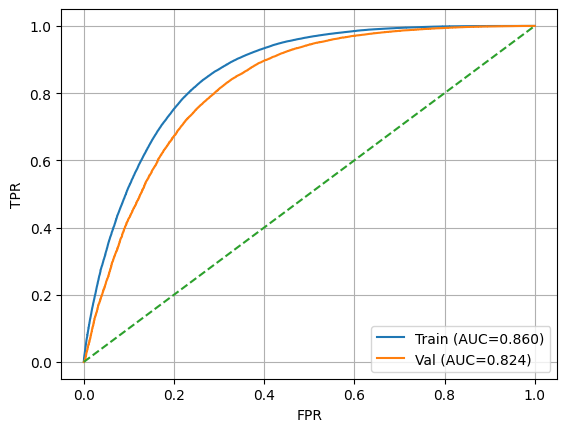

In [ ]:
plt.figure()
plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC={auc_tr:.3f})")
plt.plot(fpr_va, tpr_va, label=f"Val (AUC={auc_va:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
signal_scores     = scores[labels == 1]
background_scores = scores[labels == 0]

plt.figure(figsize=(7,5))

bins = 100

plt.hist(background_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Background')
plt.hist(signal_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Signal')

plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.semilogy()
plt.tight_layout()
plt.show()

cut = 0.97
signal_eff = (signal_scores > cut).mean()
bkg_rej = 1 - (background_scores > cut).mean()
print(signal_eff, bkg_rej)

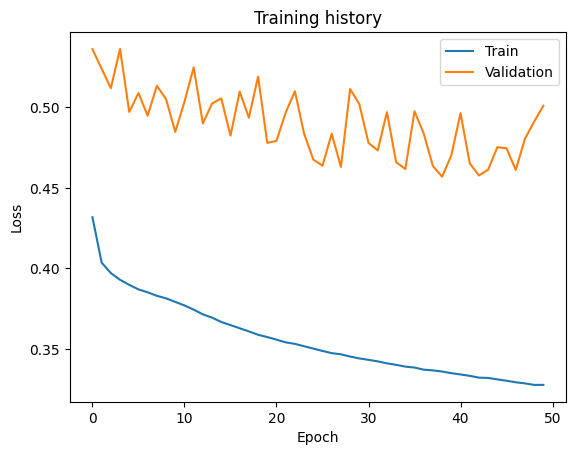

In [15]:


plt.figure()
plt.plot(train_loss_hist, label='Train')
plt.plot(val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training history')
plt.show()



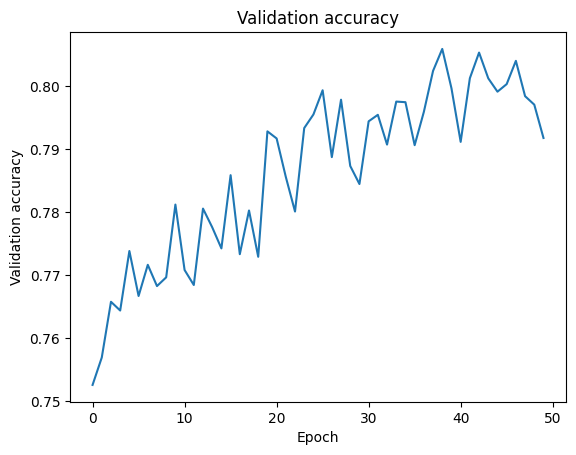

In [16]:
plt.figure()
plt.plot(val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy')
plt.show()

In [ ]:
# Test metrics

model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor)
    scores_test = torch.sigmoid(logits_test).cpu().numpy().ravel() # converts logits back to probability
    labels_test = y_test_tensor.cpu().numpy().ravel()


fpr_test, tpr_test, thresholds_test = roc_curve(y_test, scores_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f}) Val')
plt.plot(fpr_test, tpr_test, label=f'ROC (AUC = {roc_auc_test:.3f}) Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Signal vs Background ROC')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
signal_scores_test     = scores_test[labels_test == 1]
background_scores_test = scores_test[labels_test == 0]

plt.figure(figsize=(7,5))

bins = 100

plt.hist(background_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Background', color = "darkred")
plt.hist(signal_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Signal', color = "darkgreen")

plt.hist(background_scores_test,bins=bins,density=True,histtype='step',linewidth=2,label='Background Test', color = "darkred", linestyle = "--")
plt.hist(signal_scores_test,bins=bins,density=True,histtype='step',linewidth=2,label='Signal Test', color = "darkgreen", linestyle = "--")



plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.semilogy()
plt.tight_layout()
plt.show()

signal_eff_test = (signal_scores_test > cut).mean()
bkg_rej_test = 1 - (background_scores_test > cut).mean()
print(signal_eff_test, bkg_rej_test)

In [ ]:
# Plot some global information about the training across all events 

model.eval()

with torch.no_grad():
    X_tensor = torch.tensor(
        X.astype('float32').values,
        dtype=torch.float32
    )

    logits = model(X_tensor)
    p_signal = torch.sigmoid(logits).cpu().numpy().ravel()

df = df.copy()
df["p_signal"] = p_signal

display(df)

In [ ]:
def CalcEfficiency(df, label, cut):
    num = len(df[ (df.subType == label) & (df.p_signal > cut)])
    den = len(df[ (df.subType == label)])
    return num/den

print("Signal Eff:",    CalcEfficiency(df, "0nubb",  cut))
print("Tl ERej:",     1-CalcEfficiency(df, "Tl",     cut), 1/CalcEfficiency(df, "Bi",     cut))
print("Bi ERej:",     1-CalcEfficiency(df, "Bi",     cut), 1/CalcEfficiency(df, "Tl",     cut))
print("single ERej:", 1-CalcEfficiency(df, "single", cut), 1/CalcEfficiency(df, "single", cut))

plt.figure(figsize=(7,5))

bins = 100

plt.hist(df[ (df.subType == "0nubb")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='0nubb', color = "darkgreen");
plt.hist(df[ (df.subType == "Bi")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='Bi', color = "Teal");
plt.hist(df[ (df.subType == "Tl")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='Tl', color = "Orange");
plt.hist(df[ (df.subType == "single")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='Single', color = "violet");


plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.semilogy()
plt.tight_layout()
plt.show()



In [ ]:
# # Write the event ids to a file

df['subType'] = df['subType'].replace({'0nubb': 'ATPC_0nubb', 'Bi': 'ATPC_Bi_ion', 'Tl': 'ATPC_Tl_ion', 'single': 'ATPC_single'})
df_out = df[["event_id", "subType", "p_signal"]]
df_out = df_out[df_out.p_signal > 0.3]
display(df_out)


df_out[["event_id", "subType"]].to_csv("../data/SelectedEvents/ATPC_1bar_5percent.csv", index=False)

print(len(df_out[df_out.subType == "ATPC_Bi_ion"]))